**1. To download Pytorch **

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x56a9e000 @  0x7f9bd24642a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


**2. Install Latest version of Pillow**<br/>
**Note: Need to restart the runtime so that new version is fetched**

In [0]:
!python -m pip install --upgrade Pillow

Requirement already up-to-date: Pillow in /usr/local/lib/python3.6/dist-packages (5.3.0)


**3. Upload zip File train_corrected.zip.Also the trained model if required **

In [0]:
#Reference: https://stackoverflow.com/questions/47320052/load-local-data-files-to-colaboratory

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train_corrected.zip to train_corrected.zip
User uploaded file "train_corrected.zip" with length 30473941 bytes


**4. Unzip the uploaded zip file**

In [0]:
#unzip the data
! unzip train_corrected

Archive:  train_corrected.zip
  inflating: train/10002_11977.jpg   
  inflating: train/10002_12596.jpg   
  inflating: train/10002_12954.jpg   
  inflating: train/10002_13594.jpg   
  inflating: train/10002_14573.jpg   
  inflating: train/10002_20773.jpg   
  inflating: train/10002_21148.jpg   
  inflating: train/10002_21396.jpg   
  inflating: train/10002_21980.jpg   
  inflating: train/10002_22215.jpg   
  inflating: train/10002_26677.jpg   
  inflating: train/10002_27830.jpg   
  inflating: train/10002_32766.jpg   
  inflating: train/10002_34746.jpg   
  inflating: train/10002_35902.jpg   
  inflating: train/10002_35989.jpg   
  inflating: train/10002_38514.jpg   
  inflating: train/10014_32377.jpg   
  inflating: train/10014_33071.jpg   
  inflating: train/10037_19504.jpg   
  inflating: train/10037_20266.jpg   
  inflating: train/10037_27353.jpg   
  inflating: train/10037_37216.jpg   
  inflating: train/10037_38252.jpg   
  inflating: train/10037_39060.jpg   
  inflating: train/1

**5. Check list of files**

In [0]:
#verify the data uploaded and unzipped
! ls

sample_data  train  train_cars.csv  train_corrected.zip


**6. Importing necessary libraries**

In [0]:
#import the required libraries and verify pillow and torch version.
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os
import PIL
import random
import copy
from PIL import Image
from PIL import ImageOps
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import itertools
import torchvision.models as models
print(torch.__version__)
print(PIL.PILLOW_VERSION)


0.4.1
5.3.0


**7. Create a Custom DataSet to get the targets from the csv file**

In [0]:
#Reference: https://www.kaggle.com/mratsim/starting-kit-for-pytorch-deep-learning.

class TrainCarDataSet(Dataset):
  def __init__(self, image_df, img_path, f_height, f_width, transform=None):
    #validating the image name is existing in the folder or not
    assert image_df['image_name'].apply(lambda x: os.path.isfile(img_path + x.strip())).all(), \
    "Some images referenced in the CSV file were not found"
    self.img_path = img_path
    self.transform = transform
    #x will be the name of the image
    self.X_train = image_df['image_name']
    #y is the target column
    self.y_train = image_df['target']
    self.expected_h = f_height
    self.expected_w = f_width
    

  def __getitem__(self, index):
    img = Image.open(self.img_path + self.X_train[index]).convert('RGB')
    img = self.padding(img)
    if self.transform is not None:
        img = self.transform(img)

    label = classes.index(self.y_train[index])
    return img, label
  
  #pad the images to the expected height and width
  def padding(self,img):
    diff_w = self.expected_w - img.size[0]
    diff_h = self.expected_h - img.size[1]
    padding = (diff_w//2, diff_h//2, diff_w-(diff_w//2), diff_h-(diff_h//2))
    pd_image = ImageOps.expand(img, padding)
    return pd_image

  def __len__(self):
    return len(self.X_train.index)

**8. Calculate Mean and Std and for dataset.<br/>
        Height and Width Calculation for Image Resize and Padding.**

In [0]:
#Reference: https://stackoverflow.com/questions/53542974/pytorch-normalize-image-data-set

#initialize mean and std variables
r_mean = 0
g_mean = 0
b_mean = 0

r_std = 0
g_std = 0
b_std = 0

num_images = 0

#parameters for vertical images
avg_width_v = 0
avg_height_v = 0
count_v=0

#parameter for horizontal images
avg_width_h = 0
avg_height_h = 0
count_h=0


#iterate over all the images in the directory and getch the R,G,B channel and
#find mean and std for each respectively
for img in os.listdir('./train/'):
  curr_img = Image.open('./train/'+img)
  w,h = curr_img.size
  
  if h>w:
    avg_width_v+=w
    avg_height_v+=h
    count_v+=1
  else:
    avg_width_h+=w
    avg_height_h+=h
    count_h+=1
    
  #Fetch the images as RBG
  pix = np.asarray(curr_img.convert("RGB")) 
  # Red color channel
  r_chan = pix[:,:,0] 
  # Green color channel
  g_chan = pix[:,:,1]  
  # Blue color channel
  b_chan = pix[:,:,2]  
  #add current image RGB mean to overall mean variables
  r_mean +=r_chan.mean()
  g_mean +=g_chan.mean()
  b_mean +=b_chan.mean()
  #add current image RGB std to overall std variables
  r_std +=r_chan.std()
  g_std +=g_chan.std()
  b_std +=b_chan.std()
  #count number of images
  num_images+=1

#getting average height and width of the images in vertical orientation
avg_width_v /= count_v
avg_height_v /= count_v
avg_width_v = int(avg_width_v)
avg_height_v = int(avg_height_v)

#getting average height and width of the images in horizontal orientation
avg_width_h /= count_h
avg_height_h /= count_h
avg_width_h = int(avg_width_h)
avg_height_h = int(avg_height_h)


#divide total mean for each channel by number of images and 255
r_mean /=num_images*255
g_mean /=num_images*255
b_mean /=num_images*255

#divide total std for each channel by number of images and 255
r_std /=num_images*255
g_std /=num_images*255
b_std /=num_images*255

r_mean = float("{0:.4f}".format(r_mean))
g_mean = float("{0:.4f}".format(g_mean))
b_mean = float("{0:.4f}".format(b_mean))
r_std  = float("{0:.4f}".format(r_std))
g_std  = float("{0:.4f}".format(g_std))
b_std  = float("{0:.4f}".format(b_std))

print("Average width: "+str(avg_width_v)+", Average Height: "+str(avg_height_v))
print("Average width: "+str(avg_width_h)+", Average Height: "+str(avg_height_h))
f_width = avg_width_v if avg_width_v>avg_width_h else avg_width_h
f_height = avg_height_v if avg_height_v>avg_height_h else avg_height_h
print("Max width: "+str(f_width)+", Max Height: "+str(f_height))
print("--Mean--")
print("Red: "+str(r_mean)+", Green: "+str(g_mean)+", Blue: "+str(b_mean))
print("--Standard Deviation--")
print("Red: "+str(r_std)+", Green: "+str(g_std)+", Blue: "+str(b_std))

Average width: 28, Average Height: 74
Average width: 52, Average Height: 23
Max width: 52, Max Height: 74
--Mean--
Red: 0.4956, Green: 0.515, Blue: 0.5682
--Standard Deviation--
Red: 0.1928, Green: 0.2009, Blue: 0.1941


**9. Load Complete dataset and visualize dataset graphs**

Targets: 
['bus', 'cement mixer', 'crane truck', 'dedicated agricultural vehicle', 'hatchback', 'jeep', 'light truck', 'minibus', 'minivan', 'pickup', 'prime mover', 'sedan', 'tanker', 'truck', 'van']
Train set size: 10451
Valid set size: 581
Test set size: 585


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


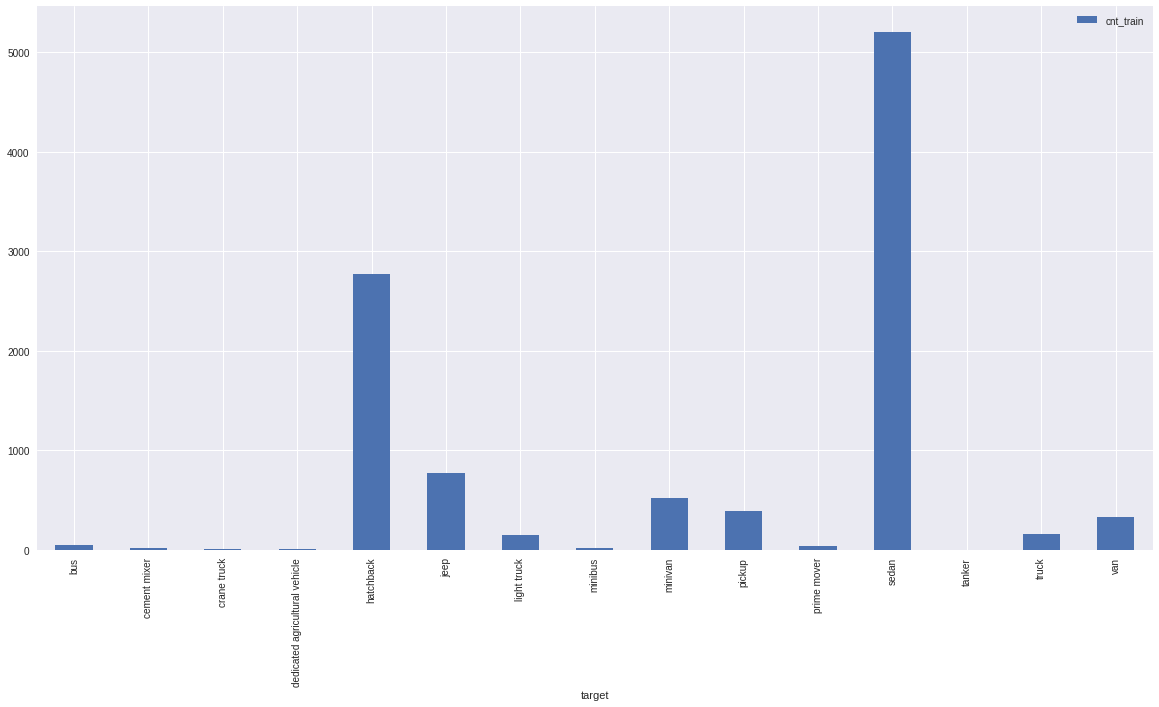

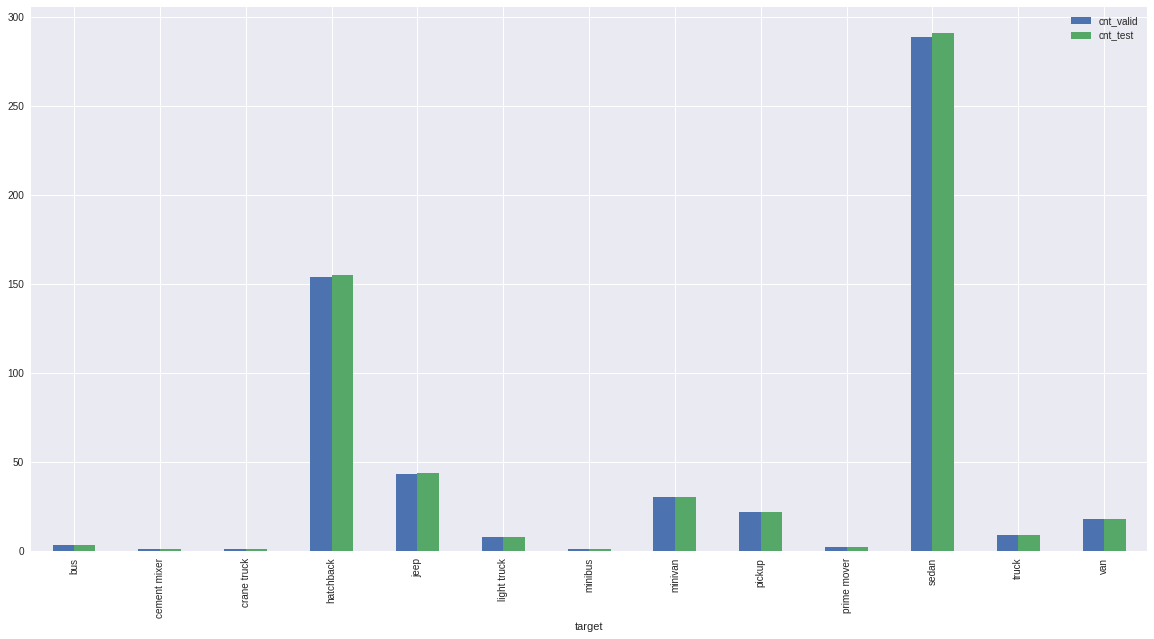

In [0]:
#Transform TrainDataSet - include augmentation
#transforms.ColorJitter(brightness=0.1*torch.randn(1),contrast=0.1*torch.randn(1), saturation=0.1*torch.randn(1),hue=0.1*torch.randn(1)),
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),
                                transforms.Resize((f_height,f_width)),transforms.ToTensor(),
                                transforms.Normalize(mean=[r_mean, g_mean, b_mean], std=[r_std, g_std, b_std])])

#Transfomr Test and validation dataset
transform_testVal = transforms.Compose([transforms.Resize((f_height,f_width)),transforms.ToTensor(),
                                transforms.Normalize(mean=[r_mean, g_mean, b_mean], std=[r_std, g_std, b_std])])
#CSV Data
csv_path='./train_cars.csv'
batch_size = 32
#pandas dataframe
image_df = pd.read_csv(csv_path,sep=',')

#list of target classes in asc order
classes = sorted(set(image_df['target']))

#Split the dataframe into test and train
train_test_df,valid_df = train_test_split(image_df, random_state=42, shuffle=True, test_size=0.05, stratify =image_df['target'] )

#further split the train dataframe into train and validation
train_df,test_df = train_test_split(train_test_df, random_state=42, shuffle=True, test_size=0.053, stratify =train_test_df['target'])

#create train, validation and test dataset
train_dataset = TrainCarDataSet(train_df.reset_index(drop=True),'train/', f_height, f_width, transform=transform_train)
valid_dataset = TrainCarDataSet(valid_df.reset_index(drop=True),'train/', f_height, f_width, transform=transform_testVal)
test_dataset = TrainCarDataSet(test_df.reset_index(drop=True),'train/', f_height, f_width, transform=transform_testVal)

#create train, validation and test dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

#create dictionary for dataset and dataloader which includes train valid and test
dict_dataset = {'train':train_dataset,'valid':valid_dataset,'test':test_dataset}
dict_dataloader = {'train':train_loader,'valid':valid_loader,'test':test_loader}

#print targets/labels
print("Targets: ")
print(classes)
#print number of train valid test lenght 
print("Train set size: "+str(len(train_dataset)))
print("Valid set size: "+str(len(valid_dataset)))
print("Test set size: "+str(len(test_dataset)))

train_trgt = train_df.groupby(by='target', as_index=False).agg({'image_name': pd.Series.nunique}).rename(columns={'image_name': 'cnt_train'})
valid_trgt = valid_df.groupby(by='target', as_index=False).agg({'image_name': pd.Series.nunique}).rename(columns={'image_name': 'cnt_valid'})
test_trgt = test_df.groupby(by='target', as_index=False).agg({'image_name': pd.Series.nunique}).rename(columns={'image_name': 'cnt_test'})
valid_test_df=df =pd.merge(test_trgt,valid_trgt,on='target')
#plot data in training dataset
train_trgt.plot(x="target", y=["cnt_train"], kind="bar",figsize=(20,10))
#plot data in valid and test dataset
valid_test_df.plot(x="target", y=["cnt_valid","cnt_test"], kind="bar",figsize=(20,10))

**10. Visualize Train DataLoader images**

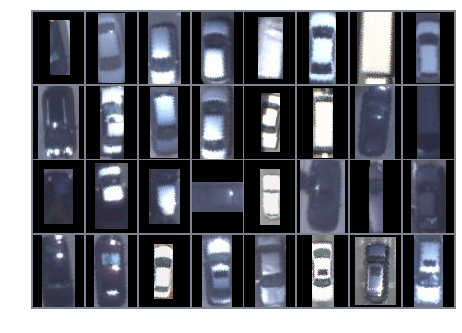

In [0]:
#Reference: https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/
#Plot train images to see the padded and resized images.

dataiter = iter(dict_dataloader['train'])
images, labels = dataiter.next()

def imshow(img, title=None):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([r_mean, g_mean, b_mean])
  std = np.array([r_std, g_std, b_std])
  img = std * img + mean
  plt.imshow(img)
  plt.axis('off')
  #if title is not None:
      #plt.title(title)


# Make a grid from batch
grid = torchvision.utils.make_grid(images)

imshow(grid, title=[classes[x] for x in labels])

**11. Custom CNN Model**

In [0]:
#Reference: https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864
#Note this model is not in use
class CNNModel(nn.Module):
  def __init__(self, num_classes=15):
    super(CNNModel, self).__init__()
    
    #convolution layer 1
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2)
    #self.pool = nn.AvgPool2d(kernel_size=2)
    
    #convolution layer 2
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2)
    #self.pool = nn.AvgPool2d(kernel_size=2)

    #convolution layer 3
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.relu3 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2)
    #self.pool = nn.AvgPool2d(kernel_size=2)

    #convolution layer 4
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.relu4 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2)
    #self.pool = nn.AvgPool2d(kernel_size=2)

    self.fc = nn.Linear(in_features=128*4*3, out_features=len(classes))

  def forward(self, input):
    
    output = self.conv1(input)
    output = self.relu1(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.relu2(output)

    output = self.pool(output)

    output = self.conv3(output)
    output = self.relu3(output)

    output = self.pool(output)

    output = self.conv4(output)
    output = self.relu4(output)

    output = self.pool(output)

    output = output.view(-1,128*4*3)

    output = self.fc(output)

    return output

**12. Select Models from the available list to test**

In [0]:
#create model based on the model name passed
def createModel(model_name, classes_len=15):  
  cnn_model= None
  #initialize model based on the model name given
  if model_name == "cnnmodel":
    #resnet18
    cnn_model = CNNModel()
  if model_name == "resnet18":
    #resnet18
    cnn_model = models.resnet18(pretrained=False)
    cnn_model.avgpool = nn.AdaptiveAvgPool2d(1)
    num_ftrs = cnn_model.fc.in_features
    cnn_model.fc = nn.Linear(num_ftrs, classes_len)
  elif model_name == "resnet34":
    #resnet34
    cnn_model = models.resnet34(pretrained=False)
    cnn_model.avgpool = nn.AdaptiveAvgPool2d(1)
    num_ftrs = cnn_model.fc.in_features
    cnn_model.fc = nn.Linear(num_ftrs, classes_len)
  else:
    print("Enter Correct Model Name..")
    
  return cnn_model

**13. Create CNN model class and Calculate loss and accuracy**

In [0]:
# Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

#Create model object pass model_name based on the model you want to train
select_model = "resnet34"
cnn = createModel(select_model,len(classes))
cnn.cuda()

# Hyper Parameters
num_epochs = 22
batch_size = 32
learning_rate = 0.001

validation_acc=[]
training_acc=[]
validation_loss=[]
training_loss=[]

def trainCNNModel():
  
  #for getting the best model and accuracy
  best_model = copy.deepcopy(cnn.state_dict())
  best_acc = 0.0
  
  # Loss and Optimizer
  criterion = nn.CrossEntropyLoss()
  #weight decay is applied for L2 regularization so that the model doesn't memorize the training set and is able to generalize well.
  optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate, weight_decay=1e-3)
  #to reduce the learning rate after 15 epoc iterations
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

  # Train the Model
  for epoch in range(num_epochs):

    # Each epoch has a training and validation phase
    for mode in ['train', 'valid']:
      if mode == 'train':
          scheduler.step()
          cnn.train(True)  # Set model to training mode
      else:
          cnn.eval() # Set model to evaluate mode


      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for i, (images, labels) in enumerate(dict_dataloader[mode]):
        #move image and label variables to gpu
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()

        with torch.set_grad_enabled(mode == 'train'):
          #clear gradient wrt parameters
          optimizer.zero_grad()
          #forwad pass to get output
          outputs = cnn(images)
          #get predictions
          _, preds = torch.max(outputs, 1)
          #calculate loss - crossentropy
          loss = criterion(outputs, labels)

          #perfrom only for train dataloader
          if mode == 'train':
            # fetch gradient wrt parameters
            loss.backward()
            # update parameters
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        #sum up all the values with correct predictions
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dict_dataset[mode])
      epoch_acc = running_corrects.double() / len(dict_dataset[mode])

      print('epoch {}: {} Loss: {:.4f} Accuracy: {:.4f}'.format(epoch,mode, epoch_loss, epoch_acc))

      if mode =='valid':
        validation_acc.append(epoch_acc)
        validation_loss.append(epoch_loss)
        # In case of validation loader if current accuracy is greater then best accuracy update best accuracy and model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(cnn.state_dict())
      else:
        training_acc.append(epoch_acc)
        training_loss.append(epoch_loss)

  print('Best val Acc: {:4f}'.format(best_acc))
  #cnn.load_state_dict(best_model)
  torch.save(best_model, 'predictVehicles.pt')
  print("--Model Saved Successfully--")
  return best_model

**14. Load trained Model or Train it again:**

In [0]:
#Modify this parameter to train the model or load the existing model
pretrained = True

if pretrained:
  cnn.load_state_dict(torch.load('predictVehicles.pt'))
else:
  cnn.load_state_dict(trainCNNModel())

**15. Function for Accuracy Score Graph and Loss Graph wrt epochs**

In [0]:
def plotGraphs():
  #Plot Training accuracy and validation accuracy for each epoch iteration
  plt.title("Score vs. Epochs")
  plt.xlabel("Epoch Iteration")
  plt.ylabel("Score")
  plt.plot(range(1,num_epochs+1), training_acc, 'o-', color="r", label="Training Score")
  plt.plot(range(1,num_epochs+1), validation_acc, 'o-', color="g", label="Validation Score")
  plt.ylim((0.5,0.9))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()

  #Plot Training loss and validation loss for each epoch iteration
  plt.title("Loss vs. Epochs")
  plt.xlabel("Epoch Iteration")
  plt.ylabel("Loss")
  plt.plot(range(1,num_epochs+1), training_loss, 'o-', color="r", label="Training Loss")
  plt.plot(range(1,num_epochs+1), validation_loss, 'o-', color="g", label="Validation Loss")
  plt.ylim((0,1.3))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()

**16. Plot the Learning Curves incase of pretrained is false**

In [0]:
if not pretrained:
  plotGraphs()

**17. Function For Plotting Confusion Matrix**

In [0]:
#Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm,target_names):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')
    title = "Confusion Matrix"

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, "{:,}".format(cm[i, j]),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

**18. Evaluate with Test dataloader**

Test Accuracy of the model:75.00%
Precision: 73.75%
Recall: 75.04%
F1 Score: 73.84%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


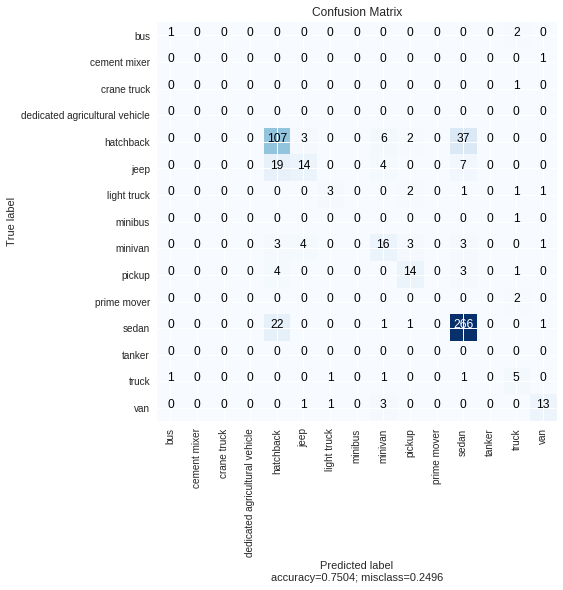

In [0]:
#Reference: https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
cnn.eval()
correct = 0
total = 0
y_pred = []
y_actual = []
confusion_matrix = torch.zeros(len(classes), len(classes), dtype=torch.int32)

for images, labels in dict_dataloader['test']:
  images = Variable(images).cuda()
  outputs = cnn(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted.cpu() == labels).sum()
  for true_lbl, pred_lbl in zip(labels.view(-1), predicted.cpu().view(-1)):
    #increment particular value in confusion matrix
    confusion_matrix[true_lbl, pred_lbl] += 1
    #create a predicted value and actual value list
    y_pred.append(pred_lbl)
    y_actual.append(true_lbl)
    
print('Test Accuracy of the model:{:0.2f}%'.format(100 * correct / total))

#precision score:
print('Precision: {:0.2f}%'.format(precision_score(y_actual, y_pred, average='weighted')*100))
print('Recall: {:0.2f}%'.format(recall_score(y_actual, y_pred, average='weighted')*100))
print('F1 Score: {:0.2f}%'.format(f1_score(y_actual, y_pred, average='weighted')*100))

#plot the confusion matrix
plot_confusion_matrix(cm = confusion_matrix.numpy(), target_names = classes)